In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ORAN_dataset import *

File config

In [2]:
# Notebook config
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLc', 3: 'CTRL'}
font = {'size'   : 22}
matplotlib.rc('font', **font)
np.random.seed(42)

ds_pkl_path = "../logs/"
# Data file config
# Trial 7
ds_file = "SingleUE/dataset__emuc__Trial7_Trial8__slice16_singleUE_raw_CNTRL_trial7-trial8_raw__globalnorm.pkl"
norm_param_path = "../logs/global__cols_maxmin__CNTRL_trial7-trial8_raw_slice16.pkl"
"""
ds_pkl_path = "../logs_dante/"
# Data file config
# Trial 7 - 8
ds_file = "SingleUE/dataset__emuc__Trial7_Trial8__slice32_singleUE_raw_trial7__slice32__newcollect_meanthr__globalnorm.pkl"
norm_param_path = "../logs_dante/global__cols_maxmin__trial7__slice32__newcollect_meanthr_slice32.pkl"
"""

# Trial 1-6
#ds_file = "SingleUE/prev_experiments/dataset__emuc__Trial1_Trial2_Trial3_Trial4_Trial5_Trial6__slice16__globalnorm.pkl"
#norm_param_path = "../logs/SingleUE/prev_experiments/global__cols_maxmin__prevexp_globalnorm_slice16.pkl"
ds_path = "../"

T = int(norm_param_path.split('slice')[-1].split('.')[0])

In [3]:
args = {
    "ds_file": [ds_file],
    "isNorm": True,
    "ds_path": ds_pkl_path,
    "norm_param_path": norm_param_path,
    "relabel_train": False
}
    
print("--- Loading Train dataset without relabeling...")
# Not relabeled
ds_train_nr = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_nr.info()
print(ds_info)
print("--- Loading Train dataset relabeling...")
# Relabeled
args['relabel_train'] = True
ds_train_rel = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_rel.info()
print(ds_info)

--- Loading Train dataset without relabeling...
{'numfeats': 17, 'slice_len': 16, 'numsamps': 150217, 'nclasses': 4, 'samples_per_class': array([51668, 49014, 49107,   428])}
--- Loading Train dataset relabeling...
Initial # samps. per label (before relabeling)
	 Labels: [0 1 2 3] Count: [51668 49014 49107   428]
	Labels that contain norm < threshold [0 1 2 3] 
	Num of samples per label with norm < threshold: [ 9870 13769  6166   373]
Tot. samples relabeled (for every class): 29805
{'numfeats': 17, 'slice_len': 16, 'numsamps': 150217, 'nclasses': 4, 'samples_per_class': array([41798, 35245, 42941, 30233])}


In [4]:
# Check if X of datasets are the same 
df_rn = []
df_r = []
for i in range(len(ds_train_nr)):
    df_rn.append(ds_train_nr[i][0].flatten().numpy())
    df_r.append(ds_train_rel[i][0].flatten().numpy())
    
result = True
# Check if the lists are identical
for k in range(len(df_r)):
    if not (df_rn[k] == df_r[k]).all():
        result = False
        
# Print the result
print("The lists are identical:", result)

The lists are identical: True


In [5]:
N = 10000000
samples_per_class = [0, 0, 0, 0]
df_subset = []
df_classes_nr = []
df_classes_r = []

for i in range(len(ds_train_rel)):
    # If we have enough samples of that class do not add
    label_rel = ds_train_rel[i][1].item()
    label_nr = ds_train_nr[i][1].item()
    if samples_per_class[label_rel] < N:
        df_subset.append(ds_train_rel[i][0].flatten().numpy())
        df_classes_r.append(label_rel)
        samples_per_class[ds_train_rel[i][1].item()] += 1
        df_classes_nr.append(label_nr)
        

df_subset = np.array(df_subset)

In [6]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto',init='random', perplexity=50, n_iter=1000, random_state=1989)
tsne_results = tsne.fit_transform(df_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 150217 samples in 0.020s...
[t-SNE] Computed neighbors for 150217 samples in 417.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 150217
[t-SNE] Computed conditional probabilities for sample 2000 / 150217
[t-SNE] Computed conditional probabilities for sample 3000 / 150217
[t-SNE] Computed conditional probabilities for sample 4000 / 150217
[t-SNE] Computed conditional probabilities for sample 5000 / 150217
[t-SNE] Computed conditional probabilities for sample 6000 / 150217
[t-SNE] Computed conditional probabilities for sample 7000 / 150217
[t-SNE] Computed conditional probabilities for sample 8000 / 150217
[t-SNE] Computed conditional probabilities for sample 9000 / 150217
[t-SNE] Computed conditional probabilities for sample 10000 / 150217
[t-SNE] Computed conditional probabilities for sample 11000 / 150217
[t-SNE] Computed conditional probabilities for sample 12000 / 150217
[t-SNE] Computed conditional prob

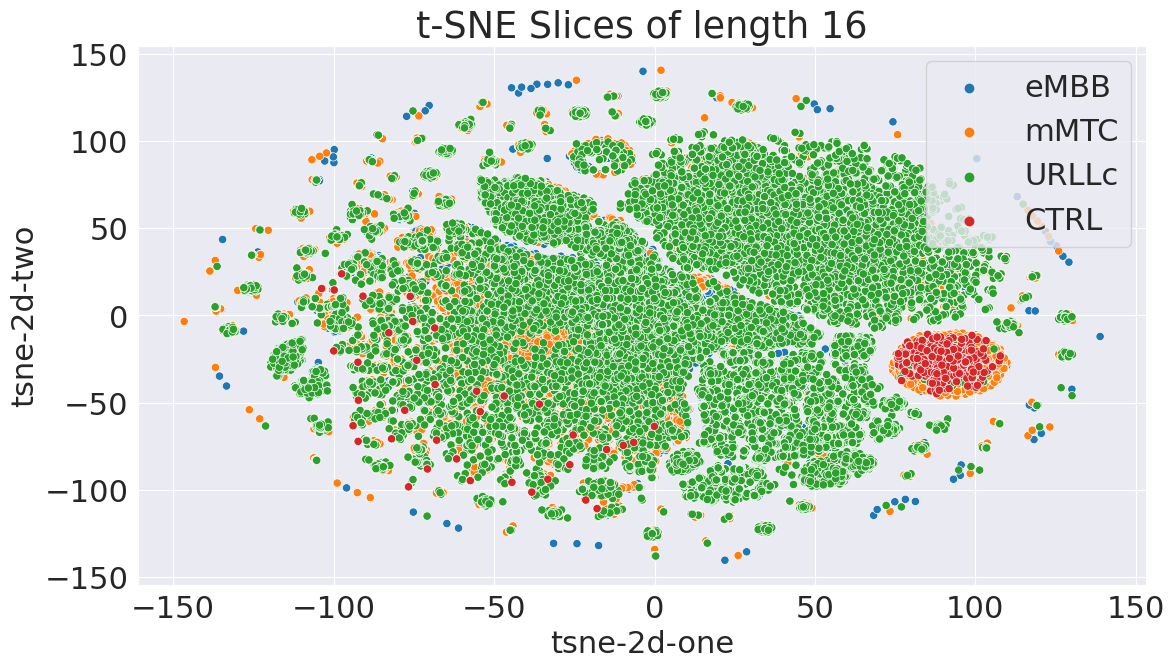

In [7]:
fig = plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_nr
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T}')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Before relabeling Slice {T}.png", transparent=True)

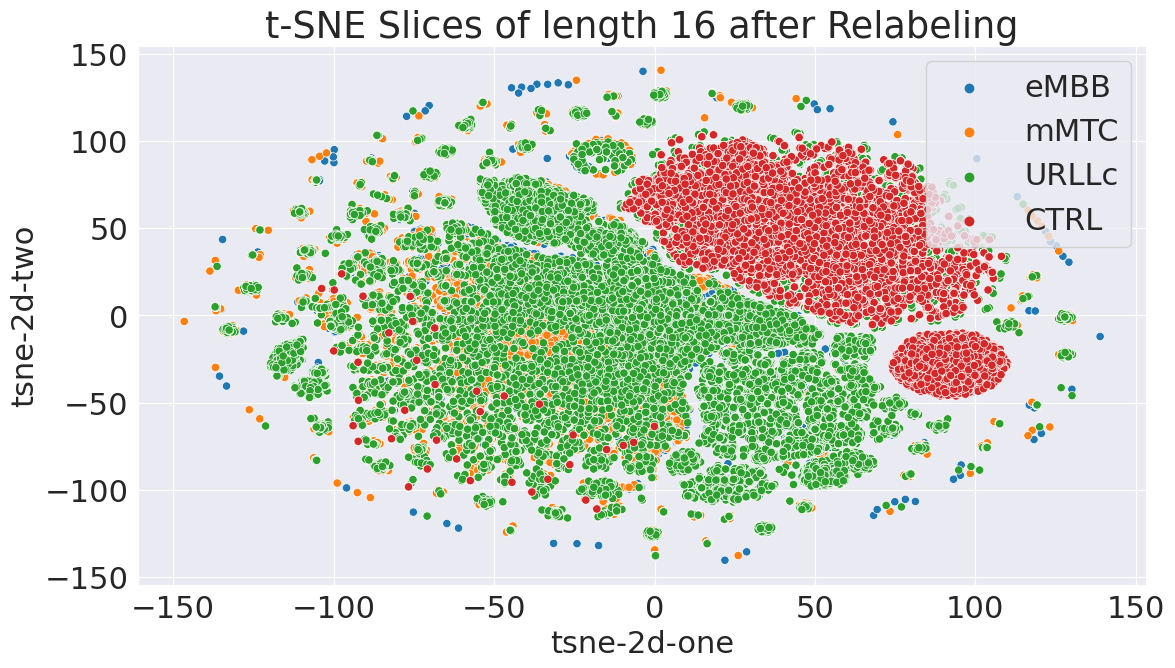

In [8]:
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_r
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T} after Relabeling')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Relabeled Slice {T}.png", transparent=True)

In [9]:
df_subset.shape

(150217, 272)

In [10]:
df_subset_og_shape = df_subset.reshape((df_subset.shape[0],T,17))

# T-SNE visualization with sample plot
In order to better visualize the output of T-SNE on dataset, we plot a random selection of samples, each of them centered at the relative coordinate point assigned by T-SNE in the 2d space. This help us spots the similarity in the cluster/region learned by T-SNE for a given dataset. In the code below, we first define the function to allow such alternative visualization, then we randomly sample 3000 samples from the original set and plot them on the 2d plane.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_tsne(images, tsne_coords, labels, image_scale):
    # Create a new figure
    fig, ax = plt.subplots(figsize=(15,9))
    
    # Plot the scatter plot using t-SNE coordinates
    ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=0, c=labels, cmap='viridis')
    
    # Set limits for the plot
    ax.set_xlim(tsne_coords[:, 0].min(), tsne_coords[:, 0].max())
    ax.set_ylim(tsne_coords[:, 1].min(), tsne_coords[:, 1].max())

    # Loop through each point and add the associated image
    for i, (image, coord) in enumerate(zip(images, tsne_coords)):
        # Get the coordinates of the point
        x, y = coord
        
        # Define the extent of the image to be plotted
        extent = [x - image_scale/2, x + image_scale/2, y - image_scale/2, y + image_scale/2]
        
        # Plot the image at the given coordinates
        ax.imshow(image, cmap='plasma', extent=extent, aspect='auto', zorder=-1)
    
    # Show the plot
    plt.show()



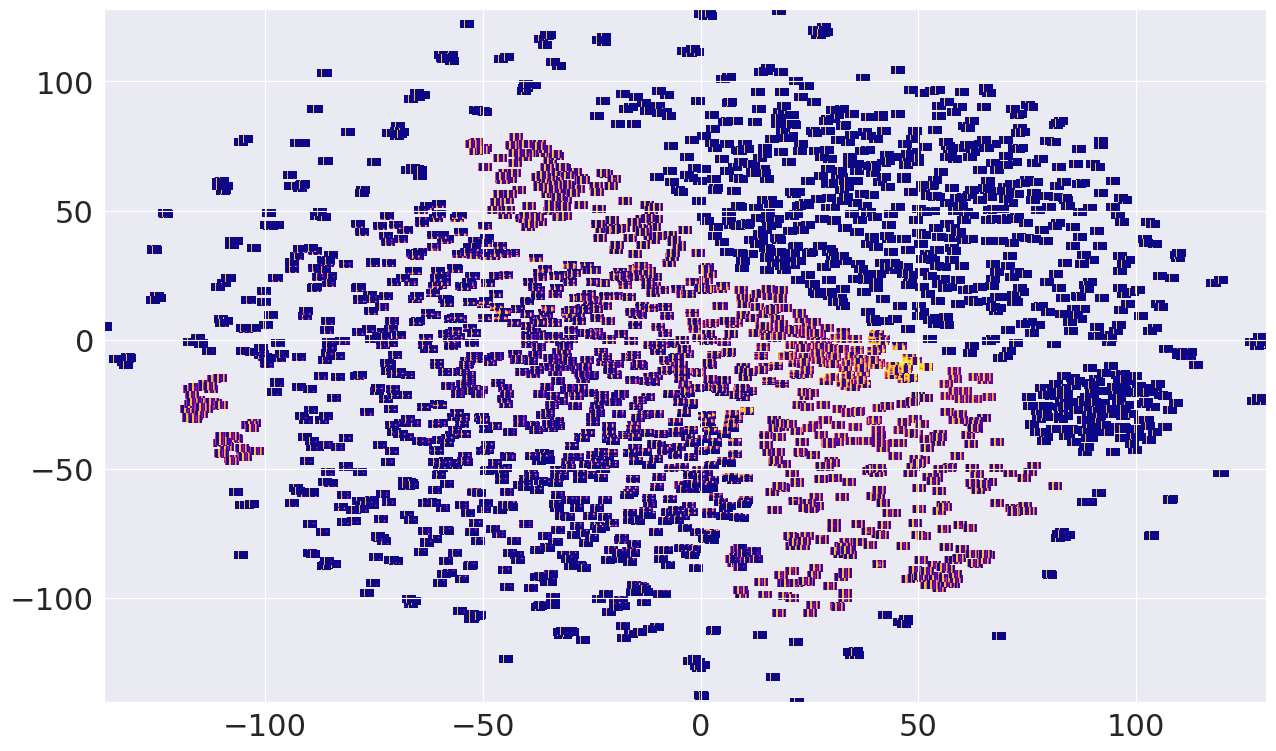

In [12]:
# Example usage
limit=3000
rand_ixs = np.random.choice(list(range(df_subset_og_shape.shape[0])), size=(limit,), )
plot_images_with_tsne(df_subset_og_shape[rand_ixs], tsne_results[rand_ixs], np.array(df_classes_nr)[rand_ixs], image_scale=3)

In [13]:

# creating 3d plot using matplotlib  
# in python 
#import matplotlib
#matplotlib.use("nbagg")
# for creating a responsive plot 
%matplotlib widget 

# importing required libraries 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 

In [14]:
tsne3d = TSNE(n_components=3, verbose=1, learning_rate='auto',init='random', perplexity=50, n_iter=1000, random_state=1989)
tsne3d_results = tsne3d.fit_transform(df_subset)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 150217 samples in 0.021s...
[t-SNE] Computed neighbors for 150217 samples in 433.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 150217
[t-SNE] Computed conditional probabilities for sample 2000 / 150217
[t-SNE] Computed conditional probabilities for sample 3000 / 150217
[t-SNE] Computed conditional probabilities for sample 4000 / 150217
[t-SNE] Computed conditional probabilities for sample 5000 / 150217
[t-SNE] Computed conditional probabilities for sample 6000 / 150217
[t-SNE] Computed conditional probabilities for sample 7000 / 150217
[t-SNE] Computed conditional probabilities for sample 8000 / 150217
[t-SNE] Computed conditional probabilities for sample 9000 / 150217
[t-SNE] Computed conditional probabilities for sample 10000 / 150217
[t-SNE] Computed conditional probabilities for sample 11000 / 150217
[t-SNE] Computed conditional probabilities for sample 12000 / 150217
[t-SNE] Computed conditional prob

(150217, 3)


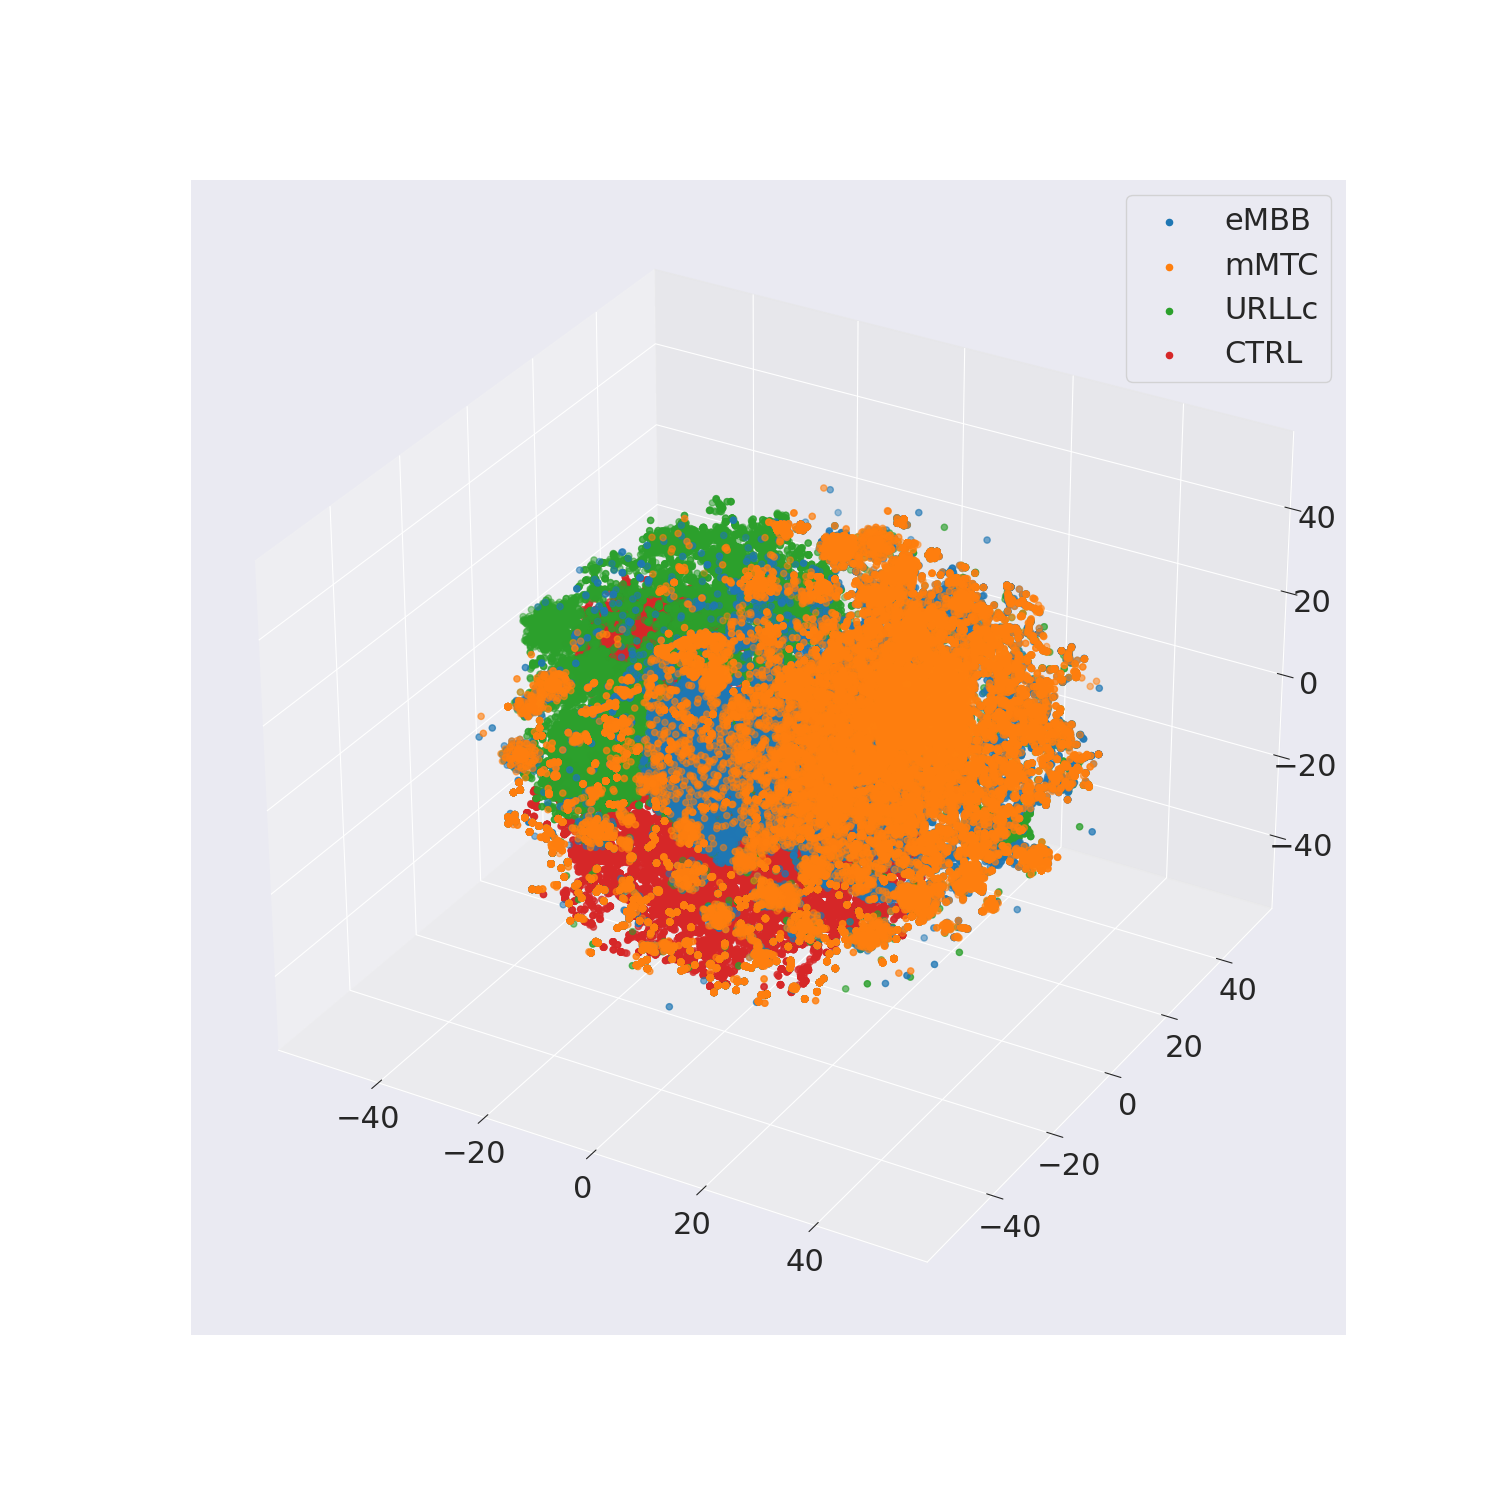

In [16]:
print(tsne3d_results.shape)
X_tsne = tsne3d_results
labels = np.array(df_classes_r)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# Plot points with labels
for label in np.unique(labels):
    indices = labels == label
    ax.scatter(X_tsne[indices, 0], X_tsne[indices, 1], X_tsne[indices, 2], label=label)

# Add labels to the points
#for i in range(len(X_tsne)):
#    ax.text(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], labels[i])

# Add legend
ax.legend(labels=['eMBB', 'mMTC', 'URLLc', 'CTRL'])

# Make the plot interactive
plt.show()